## IMPORTS

In [1]:
import os
import pickle
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, SimpleRNN, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix

## LOAD DATASET AND GET TOKENS, SLOTS AND INTENTS, AND THEIR INDEXES

In [2]:
def load_ds(fname):
    fname = os.path.join(fname)
    with open(fname, 'rb') as stream:
        ds, dicts = pickle.load(stream)
    print('Done  loading: ', fname)
    print('      samples: {:4d}'.format(len(ds['query'])))
    print('   vocab_size: {:4d}'.format(len(dicts['token_ids'])))
    print('   slot count: {:4d}'.format(len(dicts['slot_ids'])))
    print(' intent count: {:4d}'.format(len(dicts['intent_ids'])))
    return ds, dicts

In [3]:
train_ds, dicts = load_ds('atis.train.pkl')
test_ds, _ = load_ds('atis.test.pkl')

Done  loading:  atis.train.pkl
      samples: 4978
   vocab_size:  943
   slot count:  129
 intent count:   26
Done  loading:  atis.test.pkl
      samples:  893
   vocab_size:  943
   slot count:  129
 intent count:   26


In [4]:
t2i, s2i, in2i = map(dicts.get, ['token_ids', 'slot_ids', 'intent_ids'])
i2t, i2s, i2in = map(lambda d: {d[k]: k for k in d.keys()}, [t2i, s2i, in2i])
query, slots, intent = map(train_ds.get,
                           ['query', 'slot_labels', 'intent_labels'])

In [5]:
t2i_test, s2i_test, in2i_test = map(dicts.get, ['token_ids', 'slot_ids', 'intent_ids'])
i2t_test, i2s_test, i2in_test = map(lambda d: {d[k]: k for k in d.keys()}, [t2i_test, s2i_test, in2i_test])
query_test, slots_test, intent_test = map(test_ds.get,
                           ['query', 'slot_labels', 'intent_labels'])

## FORMAT TRAIN AND TEST DATASETS

In [6]:
query_complete = query + query_test
intent_complete = intent + intent_test # TURN INTO A SINGLE DATASET
padded_x = pad_sequences(query_complete) # PAD QUERIES FOR UNIFORMIZATION
y = tf.keras.utils.to_categorical(intent_complete) # TURN Y FROM CATEGORICAL TO ONE_HOT_ENCODING

In [7]:
X_train, X_test, y_train, y_test = train_test_split(padded_x, y, test_size=0.2, random_state=42)

## HYPERPARAMETERS

In [8]:
INPUT_LENGTH = 48
EMBEDDING_SIZE = 100
UNITS = 128
DROPOUT = 0.2
### Training parameters
LOSS = "categorical_crossentropy"
OPTIMIZER = "adam"
BATCH_SIZE = 32
EPOCHS = 8
LABELS = 26
EMBEDDING_DIMS = len(dicts['token_ids'])+1

## FUNCTION THAT CREATES THE MODEL

In [9]:
def create_model(type, embedding_dims, embedding_size, input_length, units, dropout, labels):
    model = Sequential()
    model.add(Embedding(embedding_dims, embedding_size, input_length=input_length))
    model.add(type(units, return_sequences=True)) #p/ mais de uma camada
    model.add(Dropout(dropout))
    model.add(type(units,return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(labels, activation='softmax'))
    return model

## FUNCTION THAT EVALUATES THE MODEL AND GENERATES THE CONFUSION MATRIX

In [10]:
def evaluate_model(model, X_test, y_test):
    Y_pred = model.predict(X_test)
    
    Y_pred_max = tf.argmax(tf.nn.softmax(Y_pred), -1).numpy().flatten()
    y_test_max =tf.argmax(y_test, axis=-1).numpy().flatten()
    y_no_pad = [(p,y) for p,y in zip(Y_pred_max, y_test_max) if y != 0]
    pred = [x[0] for x in y_no_pad]
    true = [x[1] for x in y_no_pad]

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(confusion_matrix(pred, true), annot=True, vmax=100, ax=ax)

    print(classification_report(pred, true, zero_division=False))

## MODEL CREATION AND COMPILING
Here we compare 3 different models: LSTM, RNN and GRU

## LSTM

In [11]:
model_LSTM = create_model(LSTM, EMBEDDING_DIMS, EMBEDDING_SIZE, INPUT_LENGTH, UNITS, DROPOUT, LABELS)
model_LSTM.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=["accuracy"])
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 48, 100)           94400     
_________________________________________________________________
lstm (LSTM)                  (None, 48, 128)           117248    
_________________________________________________________________
dropout (Dropout)            (None, 48, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 26)                3354      
Total params: 346,586
Trainable params: 346,586
Non-trainable params: 0
__________________________________________________

In [12]:
history = model_LSTM.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs=EPOCHS,validation_split=0.15,verbose=2)

Epoch 1/8
125/125 - 24s - loss: 1.3461 - accuracy: 0.7201 - val_loss: 1.0941 - val_accuracy: 0.7518
Epoch 2/8
125/125 - 23s - loss: 1.1619 - accuracy: 0.7281 - val_loss: 0.7481 - val_accuracy: 0.8071
Epoch 3/8
125/125 - 17s - loss: 0.7069 - accuracy: 0.8224 - val_loss: 0.5002 - val_accuracy: 0.8723
Epoch 4/8
125/125 - 13s - loss: 0.4928 - accuracy: 0.8730 - val_loss: 0.3939 - val_accuracy: 0.9035
Epoch 5/8
125/125 - 13s - loss: 0.3606 - accuracy: 0.8990 - val_loss: 0.3546 - val_accuracy: 0.9007
Epoch 6/8
125/125 - 13s - loss: 0.2943 - accuracy: 0.9186 - val_loss: 0.3338 - val_accuracy: 0.9163
Epoch 7/8
125/125 - 13s - loss: 0.2510 - accuracy: 0.9301 - val_loss: 0.2695 - val_accuracy: 0.9404
Epoch 8/8
125/125 - 13s - loss: 0.1946 - accuracy: 0.9471 - val_loss: 0.2387 - val_accuracy: 0.9418


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.53      0.80      0.64        10
           2       0.00      0.00      0.00         0
           3       0.98      0.88      0.93       106
           4       0.00      0.00      0.00         0
           6       0.91      0.86      0.88        49
           8       0.43      0.33      0.38         9
           9       0.90      0.75      0.82        12
          11       0.00      0.00      0.00         0
          13       0.75      0.60      0.67         5
          14       0.98      0.99      0.99       863
          15       0.40      0.22      0.29         9
          17       0.00      0.00      0.00         0
          19       0.50      0.44      0.47         9
          20       0.00      0.00      0.00         0
          21       0.96      0.96      0.96        48
          23       0.00      0.00      0.00         0
          24       0.82    

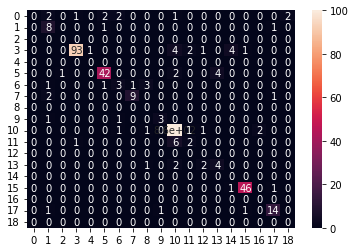

In [13]:
evaluate_model(model_LSTM, X_test, y_test)

## RNN MODEL

In [14]:
model_SimpleRNN = create_model(SimpleRNN, EMBEDDING_DIMS, EMBEDDING_SIZE, INPUT_LENGTH, UNITS, DROPOUT, LABELS)
model_SimpleRNN.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=["accuracy"])
model_SimpleRNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 100)           94400     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 48, 128)           29312     
_________________________________________________________________
dropout_2 (Dropout)          (None, 48, 128)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                3354      
Total params: 159,962
Trainable params: 159,962
Non-trainable params: 0
________________________________________________

In [15]:
history = model_SimpleRNN.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs=EPOCHS,validation_split=0.15,verbose=2)

Epoch 1/8
125/125 - 7s - loss: 1.2636 - accuracy: 0.7204 - val_loss: 0.8942 - val_accuracy: 0.7816
Epoch 2/8
125/125 - 4s - loss: 0.7734 - accuracy: 0.8181 - val_loss: 0.5779 - val_accuracy: 0.8667
Epoch 3/8
125/125 - 4s - loss: 0.4518 - accuracy: 0.8870 - val_loss: 0.3743 - val_accuracy: 0.9135
Epoch 4/8
125/125 - 4s - loss: 0.3177 - accuracy: 0.9166 - val_loss: 0.3750 - val_accuracy: 0.9149
Epoch 5/8
125/125 - 4s - loss: 0.2317 - accuracy: 0.9421 - val_loss: 0.2823 - val_accuracy: 0.9319
Epoch 6/8
125/125 - 4s - loss: 0.1507 - accuracy: 0.9634 - val_loss: 0.4338 - val_accuracy: 0.8851
Epoch 7/8
125/125 - 4s - loss: 0.1177 - accuracy: 0.9722 - val_loss: 0.2859 - val_accuracy: 0.9404
Epoch 8/8
125/125 - 4s - loss: 0.0606 - accuracy: 0.9872 - val_loss: 0.2928 - val_accuracy: 0.9319


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.47      0.64      0.54        11
           2       0.00      0.00      0.00         0
           3       0.96      0.88      0.91       104
           4       0.00      0.00      0.00         0
           6       0.76      0.80      0.78        44
           8       0.86      0.86      0.86         7
           9       0.80      0.89      0.84         9
          11       0.40      1.00      0.57         2
          13       1.00      0.67      0.80         6
          14       0.99      0.97      0.98       886
          15       0.40      0.67      0.50         3
          17       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         1
          20       0.60      0.38      0.46         8
          21       0.94      1.00      0.97        45
          23       0.00      0.00      0.00         0
          24       0.53    

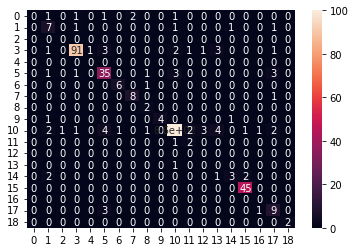

In [16]:
evaluate_model(model_SimpleRNN, X_test, y_test)

## GRU MODEL

In [17]:
model_GRU = create_model(GRU, EMBEDDING_DIMS, EMBEDDING_SIZE, INPUT_LENGTH, UNITS, DROPOUT, LABELS)
model_GRU.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=["accuracy"])
model_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 48, 100)           94400     
_________________________________________________________________
gru (GRU)                    (None, 48, 128)           88320     
_________________________________________________________________
dropout_4 (Dropout)          (None, 48, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 26)                3354      
Total params: 285,146
Trainable params: 285,146
Non-trainable params: 0
________________________________________________

In [18]:
history = model_GRU.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs=EPOCHS,validation_split=0.15,verbose=2)

Epoch 1/8
125/125 - 18s - loss: 1.2190 - accuracy: 0.7347 - val_loss: 0.7029 - val_accuracy: 0.7972
Epoch 2/8
125/125 - 12s - loss: 0.6351 - accuracy: 0.8424 - val_loss: 0.4844 - val_accuracy: 0.8837
Epoch 3/8
125/125 - 13s - loss: 0.4070 - accuracy: 0.8915 - val_loss: 0.3020 - val_accuracy: 0.9206
Epoch 4/8
125/125 - 13s - loss: 0.2480 - accuracy: 0.9308 - val_loss: 0.2451 - val_accuracy: 0.9404
Epoch 5/8
125/125 - 11s - loss: 0.1574 - accuracy: 0.9582 - val_loss: 0.1906 - val_accuracy: 0.9489
Epoch 6/8
125/125 - 13s - loss: 0.1033 - accuracy: 0.9739 - val_loss: 0.1894 - val_accuracy: 0.9603
Epoch 7/8
125/125 - 10s - loss: 0.0617 - accuracy: 0.9852 - val_loss: 0.1780 - val_accuracy: 0.9645
Epoch 8/8
125/125 - 10s - loss: 0.0567 - accuracy: 0.9865 - val_loss: 0.1745 - val_accuracy: 0.9702


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.93      0.93      0.93        15
           2       0.00      0.00      0.00         0
           3       0.98      0.98      0.98        95
           4       0.00      0.00      0.00         0
           6       0.96      0.98      0.97        45
           8       0.71      0.83      0.77         6
           9       1.00      0.83      0.91        12
          11       0.60      0.60      0.60         5
          13       1.00      0.80      0.89         5
          14       0.99      0.99      0.99       874
          15       0.80      0.57      0.67         7
          17       0.75      1.00      0.86         3
          19       0.75      0.75      0.75         8
          20       1.00      1.00      1.00         5
          21       1.00      0.96      0.98        50
          23       0.00      0.00      0.00         0
          24       0.88    

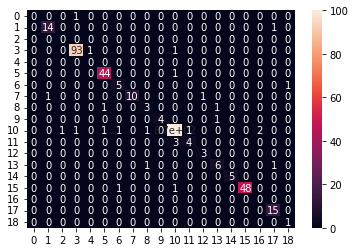

In [19]:
evaluate_model(model_GRU, X_test, y_test)